
# Projeto — Previsão de Atraso de Entrega (Olist)

**Objetivo**: construir um pipeline **robusto, limpo e sem vazamento** para prever **atraso de entrega** em pedidos da Olist, adequado para **portfólio profissional**.

## Escopo
1. Carregamento de dados e *schema* mínimo
2. *Merges* eficientes e seleção de colunas
3. *Feature Engineering* (região, sazonalidade/feriados, distância geográfica, razões e interações)
4. Conjunto de *features* **sem vazamento**
5. *Split* estratificado, *pipeline* de *preprocessing*
6. Modelo principal: **XGBoost** com **RandomizedSearchCV**
7. Otimização de *threshold* por **F1** e por **custo de negócio**
8. Avaliação (ROC, PR, matriz de confusão)
9. Importância de *features*
10. Persistência do modelo e função de inferência


## 1. Setup

In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Plotting (somente matplotlib; 1 gráfico por figura; sem estilos de cor customizados)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, average_precision_score, f1_score,
                             precision_score, recall_score, roc_curve)

# Modelos
from xgboost import XGBClassifier

# Persistência
import joblib

# Aleatoriedade reprodutível
SEED = 42
np.random.seed(SEED)
os.environ["OLIST_BASE_PATH"] = "/home/olavo-dalberto/delay_forecast_olist/data"

## 2. Carregamento de dados

In [2]:

BASE_PATH = os.environ.get("OLIST_BASE_PATH", "")

def load_olist_from_csv(base_path):
    paths = {
        "orders": "olist_orders_dataset.csv",
        "customers": "olist_customers_dataset.csv",
        "items": "olist_order_items_dataset.csv",
        "products": "olist_products_dataset.csv",
        "sellers": "olist_sellers_dataset.csv",
        "geolocation": "olist_geolocation_dataset.csv"
    }
    dfs = {}
    for k, fname in paths.items():
        fpath = os.path.join(base_path, fname)
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Arquivo não encontrado: {fpath}")
        dfs[k] = pd.read_csv(fpath)
    return dfs

try:
    dfs = load_olist_from_csv(BASE_PATH)
except Exception as e:
    # Tenta coletar dos nomes padrão, caso já existam no kernel
    raise RuntimeError(
        "Não foi possível carregar os dados automaticamente. "
        "Defina BASE_PATH com os CSVs da Olist ou garanta que os DataFrames padrão existem no ambiente."
    ) from e

for k, v in dfs.items():
    display(k, v.shape)


'orders'

(99441, 8)

'customers'

(99441, 5)

'items'

(112650, 7)

'products'

(32951, 9)

'sellers'

(3095, 4)

'geolocation'

(1000163, 5)

## 3. *Merges* eficientes e limpeza inicial

In [3]:
# Seleciona apenas colunas necessárias para reduzir uso de memória
orders = dfs["orders"][['order_id','customer_id','order_status',
                        'order_purchase_timestamp','order_approved_at',
                        'order_delivered_customer_date','order_estimated_delivery_date']].copy()

customers = dfs["customers"][['customer_id','customer_zip_code_prefix','customer_city','customer_state']].copy()

items = dfs["items"][['order_id','order_item_id','product_id','seller_id',
                      'shipping_limit_date','price','freight_value']].copy()

products = dfs["products"][['product_id','product_category_name']].copy()

sellers = dfs["sellers"][['seller_id','seller_zip_code_prefix','seller_city','seller_state']].copy()

geo = dfs["geolocation"][['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']].copy()

# Tipagem econômica
for df_ in [orders, customers, sellers, products]:
    for c in df_.select_dtypes(include='object').columns:
        df_[c] = df_[c].astype('string')

# Datas
for c in ['order_purchase_timestamp','order_approved_at',
          'order_delivered_customer_date','order_estimated_delivery_date']:
    orders[c] = pd.to_datetime(orders[c], errors='coerce')

items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'], errors='coerce')

# Agregados por pedido (itens)
items_agg = (items.groupby('order_id')
             .agg(n_items=('order_item_id','size'),
                  n_sellers=('seller_id','nunique'),
                  price_sum=('price','sum'),
                  freight_sum=('freight_value','sum'),
                  ship_deadline_max=('shipping_limit_date','max'))
             .reset_index())

# Tipo de produto por pedido (modo)
prod_map = (items.merge(products, on='product_id', how='left')
                 .groupby('order_id')['product_category_name']
                 .agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else pd.NA)
                 .reset_index()
                 .rename(columns={'product_category_name':'order_product_type'}))

# Geo agregado por CEP
geo_cust = (geo.rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix',
                                'geolocation_lat':'cust_lat','geolocation_lng':'cust_lng'})
              .groupby('customer_zip_code_prefix')[['cust_lat','cust_lng']].mean().reset_index())

geo_seller = (geo.rename(columns={'geolocation_zip_code_prefix':'seller_zip_code_prefix',
                                  'geolocation_lat':'sell_lat','geolocation_lng':'sell_lng'})
                .groupby('seller_zip_code_prefix')[['sell_lat','sell_lng']].mean().reset_index())

# Merge principal
df = (orders
      .merge(customers, on='customer_id', how='left')
      .merge(items_agg, on='order_id', how='left')
      .merge(sellers, on='order_id', how='left', how_suffixes=('', '_seller'), validate='m:1') if 'order_id' in sellers.columns else
      orders.merge(customers, on='customer_id', how='left').merge(items_agg, on='order_id', how='left')
     )

# Adiciona tipo de produto
df = df.merge(prod_map, on='order_id', how='left')

# Geo do cliente
df = df.merge(geo_cust, on='customer_zip_code_prefix', how='left')

# Geo dos sellers: precisamos do CEP do seller agregado por order_id (via items)
seller_zip_map = (items.merge(sellers[['seller_id','seller_zip_code_prefix']], on='seller_id', how='left')
                       .groupby('order_id')['seller_zip_code_prefix']
                       .agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else pd.NA)
                       .reset_index())

df = df.merge(seller_zip_map, on='order_id', how='left').merge(geo_seller, on='seller_zip_code_prefix', how='left')

print("Shape final após merges:", df.shape)
df.head()

Shape final após merges: (99441, 21)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,n_sellers,price_sum,freight_sum,ship_deadline_max,order_product_type,cust_lat,cust_lng,seller_zip_code_prefix,sell_lat,sell_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,...,1.0,29.99,8.72,2017-10-06 11:07:15,utilidades_domesticas,-23.576983,-46.587161,9350.0,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,47813,barreiras,BA,...,1.0,118.70,22.76,2018-07-30 03:24:27,perfumaria,-12.177924,-44.660711,31570.0,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,75265,vianopolis,GO,...,1.0,159.90,19.22,2018-08-13 08:55:23,automotivo,-16.745150,-48.514783,14840.0,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,59296,sao goncalo do amarante,RN,...,1.0,45.00,27.20,2017-11-23 19:45:59,pet_shop,-5.774190,-35.271143,31842.0,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,9195,santo andre,SP,...,1.0,19.90,8.72,2018-02-19 20:31:37,papelaria,-23.676370,-46.514627,8752.0,-23.543395,-46.262086


## 4. *Feature Engineering*

In [4]:
# Flags de entrega e atraso
df['was_delivered'] = df['order_delivered_customer_date'].notna().astype(int)
df['is_late'] = np.where(
    df['was_delivered'].eq(1) & (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']),
    1, 0
)

# Tempo de processamento inicial (aprovado - comprado)
df['processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600.0

# Razões e interações
df['freight_ratio'] = df['freight_sum'] / df['price_sum']
df['items_per_seller'] = df['n_items'] / df['n_sellers']

# Função haversine (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance'] = haversine(df['cust_lat'], df['cust_lng'], df['sell_lat'], df['sell_lng'])
df['has_geo'] = df['distance'].notna().astype(int)

# Região do cliente
state_to_region = {
    'AC':'Norte','AP':'Norte','AM':'Norte','PA':'Norte','RO':'Norte','RR':'Norte','TO':'Norte',
    'AL':'Nordeste','BA':'Nordeste','CE':'Nordeste','MA':'Nordeste','PB':'Nordeste','PE':'Nordeste','PI':'Nordeste','RN':'Nordeste','SE':'Nordeste',
    'DF':'Centro-Oeste','GO':'Centro-Oeste','MT':'Centro-Oeste','MS':'Centro-Oeste',
    'ES':'Sudeste','MG':'Sudeste','RJ':'Sudeste','SP':'Sudeste',
    'PR':'Sul','RS':'Sul','SC':'Sul'
}
df['customer_region'] = df['customer_state'].map(state_to_region).astype('string')

# Sazonalidade/feriados
try:
    import holidays
    years = pd.to_datetime(df['order_purchase_timestamp']).dt.year.dropna().unique().tolist()
    feriados_br = holidays.country_holidays(country='Brazil', years=years) if len(years)>0 else holidays.country_holidays(country='Brazil')
    dte = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
    df['is_holiday'] = dte.dt.date.isin(feriados_br)
    df['is_holiday_eve'] = dte.dt.date.isin([d - pd.Timedelta(days=1) for d in feriados_br])
    df['is_holiday_next'] = dte.dt.date.isin([d + pd.Timedelta(days=1) for d in feriados_br])
except Exception as e:
    df['is_holiday'] = False
    df['is_holiday_eve'] = False
    df['is_holiday_next'] = False

# Calendário básico
dte = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['purchase_month'] = dte.dt.month
df['purchase_weekday'] = dte.dt.weekday
df['is_weekend'] = df['purchase_weekday'].isin([5,6]).astype(int)

# Tratamento do tipo de produto
df['order_product_type'] = df['order_product_type'].astype('string')
df['has_product_type'] = df['order_product_type'].notna().astype(int)
df['order_product_type'] = df['order_product_type'].fillna('__unknown__')

# Sanidade: remover infinitos nas razões
for c in ['freight_ratio','items_per_seller']:
    df[c] = df[c].replace([np.inf,-np.inf], np.nan)

display(df[['was_delivered','is_late','processing_time','distance','customer_region','is_holiday']].head())


,was_delivered,is_late,processing_time,distance,customer_region,is_holiday
0,1,0,0.178333,18.576110,Sudeste,False
1,1,0,30.713889,851.495069,Nordeste,False
2,1,0,0.276111,514.410666,Centro-Oeste,False
3,1,0,0.298056,1822.226336,Nordeste,False
4,1,0,1.030556,29.676625,Sudeste,False


## 5. Conjunto para atraso (somente entregues)

In [17]:

# Mantém apenas pedidos entregues
df_model = df[df['was_delivered'] == 1].copy()

# Colunas que NUNCA entram (vazamento ou IDs)

cols_drop = [
    'is_late','order_id','customer_id',
    'order_purchase_timestamp','order_delivered_customer_date',
    'order_estimated_delivery_date','order_approved_at',
    'ship_deadline_max','shipping_limit_date',  # se existir
    'order_status'
]
cols_drop = [c for c in cols_drop if c in df_model.columns]
feature_cols = [c for c in df_model.columns if c not in cols_drop]

# Separação entre numéricas e categóricas
numeric_candidates = ['n_items','n_sellers','price_sum','freight_sum',
                      'processing_time','distance','purchase_month',
                      'purchase_weekday','is_weekend','freight_ratio','items_per_seller',
                      'has_geo', 'has_product_type', 'cust_lat', 'cust_lng', 
                      'seller_zip_code_prefix', 'sell_lat', 'sell_lng',
                      'was_delivered', 'is_holiday', 'is_holiday_eve',
                      'is_holiday_next', 'customer_zip_code_prefix']

num_cols = [c for c in numeric_candidates if c in feature_cols]
cat_cols = [c for c in feature_cols if c not in num_cols]

# Target
X = df_model.drop(columns=cols_drop).copy()
y = df_model['is_late'].astype(int).copy()

bool_cols = X.select_dtypes(include='boolean').columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype('int8')

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)
print("Shape X:", X.shape, "| y:", y.shape, "| Taxa de atraso (classe 1):", y.mean().round(3))


Numéricas: ['n_items', 'n_sellers', 'price_sum', 'freight_sum', 'processing_time', 'distance', 'purchase_month', 'purchase_weekday', 'is_weekend', 'freight_ratio', 'items_per_seller', 'has_geo', 'has_product_type', 'cust_lat', 'cust_lng', 'seller_zip_code_prefix', 'sell_lat', 'sell_lng', 'was_delivered', 'is_holiday', 'is_holiday_eve', 'is_holiday_next', 'customer_zip_code_prefix']
Categóricas: ['customer_city', 'customer_state', 'order_product_type', 'customer_region']
Shape X: (96476, 27) | y: (96476,) | Taxa de atraso (classe 1): 0.081


## 6. Split e *Preprocessing*

In [18]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector

numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_exclude=np.number)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Pipelines de pré-processamento
num_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False)) 
])

cat_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer(
    transformers=[
        ('num', num_tf, numeric_selector),
        ('cat', cat_tf, categorical_selector),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)


## 7. Utilitários de avaliação (threshold, curvas, métricas)

In [19]:

def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*(prec*rec)/(prec+rec+1e-9)
    idx = np.argmax(f1)
    return float(thr[idx]), float(prec[idx]), float(rec[idx]), float(f1[idx])

def threshold_by_cost(y_true, y_prob, cost_fp=1.0, cost_fn=5.0, n_steps=101):
    thrs = np.linspace(0.0, 1.0, n_steps)
    costs = []
    from sklearn.metrics import confusion_matrix
    for t in thrs:
        yp = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        costs.append(fp*cost_fp + fn*cost_fn)
    i = int(np.argmin(costs))
    return float(thrs[i]), float(costs[i])

def plot_pr_curve(y_true, y_prob, title="Precision-Recall"):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.show()

def plot_confusion(cm, title="Matriz de Confusão"):
    plt.figure(figsize=(4.5,4))
    # Heatmap manual simples
    plt.imshow(cm, cmap='Blues')
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, f"{val}", ha='center', va='center')
    plt.xticks([0,1], ['Prev 0','Prev 1'])
    plt.yticks([0,1], ['Real 0','Real 1'])
    plt.title(title)
    plt.xlabel('Previsto'); plt.ylabel('Real')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_prob, thr=None, label="Modelo"):
    if thr is None:
        thr, p, r, f = best_threshold_by_f1(y_true, y_prob)
    yp = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, yp)
    print(f"[{label}] Threshold={thr:.3f} | ROC-AUC={roc_auc_score(y_true, y_prob):.3f} | PR-AUC={average_precision_score(y_true, y_prob):.3f}")
    print(classification_report(y_true, yp, digits=3))
    plot_pr_curve(y_true, y_prob, title=f"Precision-Recall — {label}")
    plot_roc_curve(y_true, y_prob, title=f"ROC — {label}")
    plot_confusion(cm, title=f"Matriz de Confusão — {label}")
    return thr, cm


## 8. Modelo principal — XGBoost + RandomizedSearchCV

In [20]:
from scipy.stats import randint, uniform

scorer = 'average_precision'
scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

xgb_pipe = Pipeline(steps=[
    ('pre', pre),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='aucpr',
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        random_state=SEED
    ))
])

param_distributions = {
    'model__max_depth': randint(3, 7),
    'model__min_child_weight': randint(1, 8),
    'model__gamma': uniform(0.0, 0.3),
    'model__subsample': uniform(0.7, 0.3),
    'model__colsample_bytree': uniform(0.7, 0.3),
    'model__learning_rate': uniform(0.02, 0.06),
    'model__n_estimators': randint(800, 1800)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

rs = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=scorer, 
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=SEED
)

rs.fit(X_train, y_train)
print("Melhores parâmetros (RandomizedSearch):", rs.best_params_)
print("Melhor F1 (CV):", rs.best_score_)

best_xgb = rs.best_estimator_

# # Avaliação no teste com threshold ótimo por F1
# y_prob = best_xgb.predict_proba(X_test)[:, 1]

# prec, rec, thr = precision_recall_curve(y_test, y_prob)
# f1 = 2*(prec*rec)/(prec+rec+1e-9)
# t_best = thr[f1.argmax()]

# print(f"Threshold ótimo por F1: {t_best:.3f} | F1={f1.max():.3f}")
# print("ROC-AUC:", roc_auc_score(y_test, y_prob))
# print("PR-AUC :", average_precision_score(y_test, y_prob))

# # escolha por custo
# thr_cost, min_cost = threshold_by_cost(y_test, y_prob_test, cost_fp=1.0, cost_fn=5.0)
# print(f"Threshold ótimo por CUSTO (FP=1, FN=5): t={thr_cost:.3f} | Custo={min_cost:.1f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__colsample_bytree=0.8123620356542087, model__gamma=0.2852142919229748, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1414, model__subsample=0.8337498258560773; total time=  14.2s
[CV] END model__colsample_bytree=0.8123620356542087, model__gamma=0.2852142919229748, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1414, model__subsample=0.8337498258560773; total time=  14.9s
[CV] END model__colsample_bytree=0.8123620356542087, model__gamma=0.2852142919229748, model__learning_rate=0.0639196365086843, model__max_depth=3, model__min_child_weight=5, model__n_estimators=1414, model__subsample=0.8337498258560773; total time=  15.1s
[CV] END model__colsample_bytree=0.9165996316800473, model__gamma=0.281565812704725, model__learning_rate=0.02004672595046086, model__max_depth=6, model__min_child_weigh

In [21]:
def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*(prec*rec)/(prec+rec+1e-9)
    idx = np.argmax(f1)
    return float(thr[idx]), float(prec[idx]), float(rec[idx]), float(f1[idx])

def threshold_by_cost(y_true, y_prob, cost_fp=1.0, cost_fn=5.0, n_steps=101):
    thrs = np.linspace(0.0, 1.0, n_steps)
    costs = []
    for t in thrs:
        yp = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        costs.append(fp*cost_fp + fn*cost_fn)
    i = int(np.argmin(costs))
    return float(thrs[i]), float(costs[i])

In [ ]:
y_prob = best_xgb.predict_proba(X_test)[:, 1]

thr_f1, p_best, r_best, f1_best = best_threshold_by_f1(y_test, y_prob)
print(f"[F1] threshold={thr_f1:.3f} | Precision={p_best:.3f} | Recall={r_best:.3f} | F1={f1_best:.3f}")
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC :", average_precision_score(y_test, y_prob))

y_pred_f1 = (y_prob >= thr_f1).astype(int)
print(classification_report(y_test, y_pred_f1, digits=3))

thr_cost, min_cost = threshold_by_cost(y_test, y_prob, cost_fp=1.0, cost_fn=5.0)  # <- y_prob correto
print(f"[CUSTO] threshold={thr_cost:.3f} | custo mínimo={min_cost:.2f}")


[F1] threshold=0.601 | Precision=0.258 | Recall=0.497 | F1=0.340
ROC-AUC: 0.7756447931575228
PR-AUC : 0.27062302801775956
              precision    recall  f1-score   support

           0      0.952     0.874     0.911     17731
           1      0.258     0.497     0.340      1565

    accuracy                          0.843     19296
   macro avg      0.605     0.686     0.626     19296
weighted avg      0.895     0.843     0.865     19296

[CUSTO] threshold=0.600 | custo mínimo=6183.00


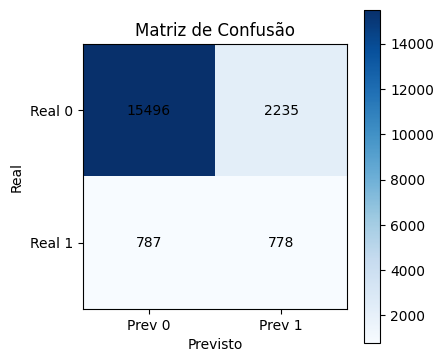

In [26]:
cm = confusion_matrix(y_test, y_pred_f1)
plot_confusion(cm)

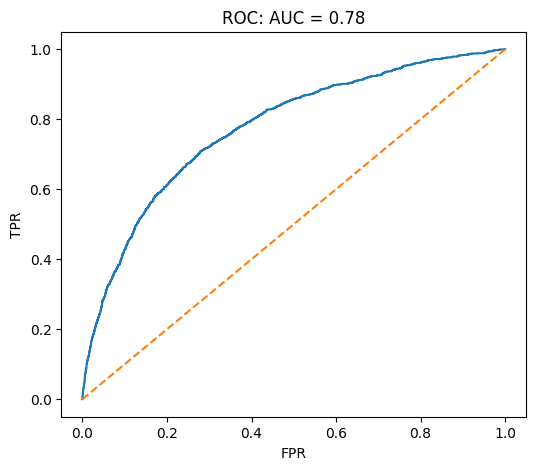

In [29]:
plot_roc_curve(y_test, y_prob, title=f"ROC: AUC = {roc_auc_score(y_test, y_prob):.2f}")

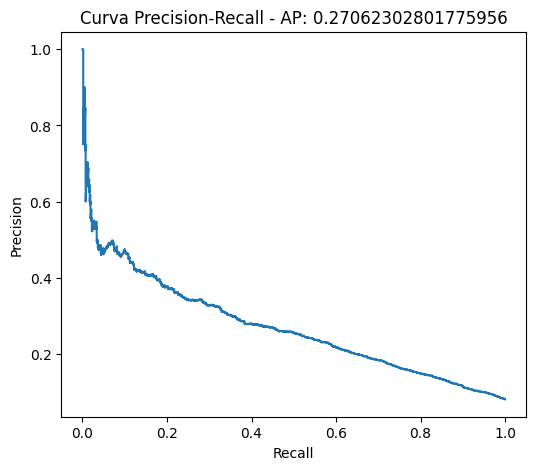

In [30]:
plot_pr_curve(y_test, y_prob, title=f"Curva Precision-Recall - AP: {average_precision_score(y_test, y_prob)}")

## 9. Importância de *features*

,feature,importance
3873,customer_state_SP,0.052892
3950,customer_region_Nordeste,0.032318
19,purchase_month,0.011109
2,n_sellers,0.009198
3866,customer_state_RJ,0.008655
3858,customer_state_MG,0.008608
2767,customer_city_porto alegre,0.006428
3853,customer_state_CE,0.005850
2941,customer_city_rio de janeiro,0.005683
3952,customer_region_Sudeste,0.005462


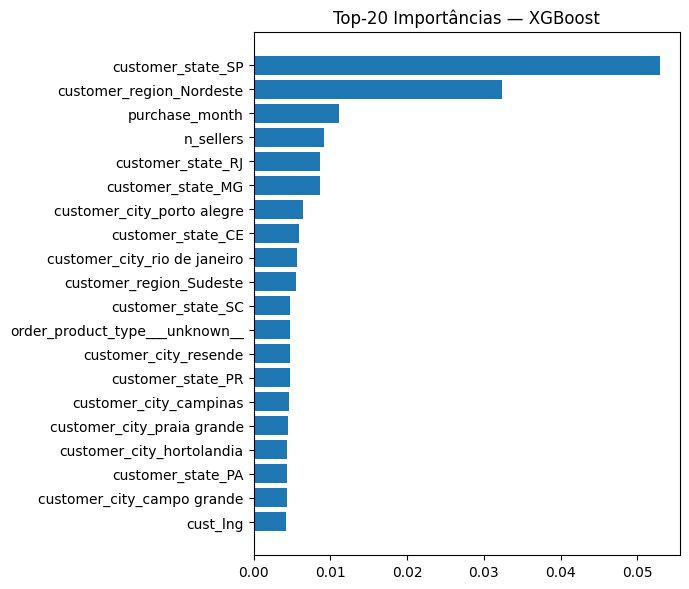

In [23]:

# Nomes pós-transformação (para árvores com OneHot)
try:
    feat_names = best_xgb.named_steps['pre'].get_feature_names_out()
    importances = best_xgb.named_steps['model'].feature_importances_
    fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    display(fi.head(25))

    # Plot simples
    topk = fi.head(20)
    plt.figure(figsize=(7,6))
    plt.barh(range(len(topk)), topk['importance'].values[::-1])
    plt.yticks(range(len(topk)), topk['feature'].values[::-1])
    plt.title("Top-20 Importâncias — XGBoost")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Não foi possível extrair importâncias:", e)


## 10. Persistência do modelo e *helper* de inferência

In [24]:

ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Salvar o pipeline completo + threshold escolhido
joblib.dump(best_xgb, os.path.join(ARTIFACT_DIR, "xgb_pipeline.joblib"))
with open(os.path.join(ARTIFACT_DIR, "xgb_threshold.json"), "w") as f:
    json.dump({"threshold_f1": thr_f1, "threshold_cost": thr_cost}, f)

print("Artefatos salvos em:", ARTIFACT_DIR)

def predict_is_late_proba(df_new: pd.DataFrame, pipeline_path=os.path.join(ARTIFACT_DIR,"xgb_pipeline.joblib")):
    """Recebe um DataFrame no mesmo schema de features (pré-merge) e retorna probabilidade de atraso.
    
    Observação: para produção é recomendável extrair o mesmo pipeline de *feature engineering* usado acima.
    Aqui assume-se que df_new já passou pelos mesmos merges/engenharia e tem as colunas `feature_cols`.
    """
    pipe = joblib.load(pipeline_path)
    # Seleciona apenas as colunas esperadas (interseção para robustez)
    expected = [c for c in pipe.named_steps['pre'].get_feature_names_out()]  # nomes expandidos
    # Para simplificar, considere adaptar para aplicar o mesmo ColumnTransformer ao df_new original.
    raise NotImplementedError("Para produção, encapsule a etapa de engenharia + preprocessor antes do modelo.")


Artefatos salvos em: ./artifacts
